# FFS comparison 

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src.algorithm.backward_feature_selection import BackwardFeatureSelector
from src.algorithm.info_theory.combo_estimators import NpeetEstimator
from src.algorithm.utils import episodes_with_len
from src.envs.lqgNdim import LQG_nD
from src.wenvs import WrapperEnv

/home/daibak/.virtualenvs/feature_sel/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%load_ext autoreload
%autoreload 2

## LGQ 4

In [3]:
weights = np.array([0.9, 0.9, 0.1, 0.1]*2)

In [4]:
Q = np.diag(weights[:4])
R = Q.copy()
env = LQG_nD(0.9, n_dim=4, Q=Q, R=R)
wenv = WrapperEnv(env, continuous_state=True, continuous_actions=True)

In [5]:
def CMIFS(trajectories, k, gamma, nproc=None, knn=3):
    fs = BackwardFeatureSelector(NpeetEstimator(k=knn), trajectories, nproc=nproc)
    return [(set(fs.idSet), 0.0)] + list(fs.try_all(k, gamma))

In [6]:
def FFS(trajectories):
    sarsar = np.vstack([np.hstack([t[:-1, :], t[1:, :]]) for t in trajectories])
    sep = trajectories[0].shape[1]
    
    sar = sarsar[:, :sep]
    sar_next = sarsar[:, sep:]
    sa = sar[:, :-1]
    r = sar[:, -1]
    sa_next = sar_next[:, :-1]    
    sa_inv = np.linalg.pinv(sa, rcond=0)
    
    P_a = sa_inv @ sa_next
    u, s, vt = np.linalg.svd(P_a)
    r_a = sa_inv @ r
    
    return u, r_a

In [7]:
def evaluateFFS(u, weights):    
    scores = []
    u_norm = np.abs(u) / np.abs(u).sum(axis=0)
    for k in range(u.shape[1], 0, -1):
        score = (weights @ u_norm[:, :k]).sum() / (k + 1)
        scores.append(score)
    scores.append(0)
    return np.array(scores)

In [8]:
def score_fs(history, weights):
    res = []
    for S in history:
        score = weights[list(S)].sum() / (len(S) + 1)
        res.append(score)
    return np.array(res)

In [9]:
def ideal_hist(weights):
    S = set(range(len(weights)))
    hist = [S.copy()]
    for i in np.argsort(weights):
        S.remove(i)
        hist.append(S.copy())
    return hist

In [10]:
k = 20
k_ahead = 20
num_ep = 1000
wenv.seed(0)

trajectories = episodes_with_len(wenv, num_ep, k+k_ahead, policy=None)

In [11]:
scores = {}
scores['Ideal'] = score_fs(ideal_hist(weights), weights)

In [12]:
u, _ = FFS(trajectories)
scores['FFS'] = evaluateFFS(u, weights)

In [13]:
cmifs_hist = list(map(lambda x: x[0], CMIFS(trajectories, k, 0.9, nproc=1)))

In [14]:
scores['CMIFS'] = score_fs(cmifs_hist, weights)

In [35]:
def plot_scores(score_dict, figsize=(9,5)):
    markers = ["x", "o", "^", "v", "s"]
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    for fs, m in zip(score_dict, markers):
        y = score_dict[fs]
        x = np.arange(len(y))
        ax.step(x, y, where='mid', label=fs, marker=m, alpha=0.5)
    ax.legend()
    plt.xlabel("Number of Features Removed")
    plt.ylabel("Score")
    plt.title("FFS Comparison")
    plt.show()
    return fig

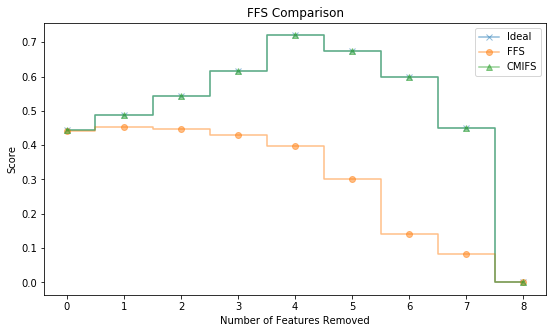

In [16]:
fig = plot_scores(scores)

In [17]:
fig.savefig("images/ffs-comparison4.png")

## LQG 7 

In [18]:
diag = np.array([0.9, 0.9, 0.5, 0.5, 0.3, 0.1, 0.1]) #np.linspace(0, 10, 5)[:0:-1]
n_fake = 0
weights = np.array((list(diag)+[0]*n_fake)*2)

In [19]:
Q = np.diag(diag)
R = Q.copy()
env = LQG_nD(0.9, n_dim=diag.shape[0], Q=Q, R=R)
wenv = WrapperEnv(env, continuous_state=True, continuous_actions=True, n_fake_features=n_fake, n_fake_actions=n_fake)

In [20]:
k = 20
k_ahead = 20
num_ep = 5000
wenv.seed(0)

trajectories = episodes_with_len(wenv, num_ep, k+k_ahead, policy=None)

In [21]:
if len(weights) > 70 and False:
    with open("benchmarks/ffs/100dim-traj.pkl", 'wb') as fp:
        pickle.dump(trajectories, fp)

In [22]:
scores = {}
scores['Ideal'] = score_fs(ideal_hist(weights), weights)

In [23]:
u, _ = FFS(trajectories)
scores['FFS'] = evaluateFFS(u, weights)

In [24]:
if len(weights) > 70 and False:
    with open("benchmarks/ffs/100dim-hist.pkl", 'rb') as fp:
        cmifs_hist = pickle.load(fp)
    cmifs_sets = list(map(lambda x: x[0], cmifs_hist))
else:
    cmifs_hist = CMIFS(trajectories, k, 0.9, knn=3, nproc=None)
    cmifs_sets = list(map(lambda x: x[0], cmifs_hist))

2019-11-22 17:55:17,922	WARNING worker.py:1438 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-11-22 17:55:17,926	INFO resource_spec.py:205 -- Starting Ray with 1.17 GiB memory available for workers and up to 0.6 GiB for objects. You can adjust these settings with ray.remote(memory=<bytes>, object_store_memory=<bytes>).


In [25]:
scores['CMIFS-k3'] = score_fs(cmifs_sets, weights)

In [26]:
if len(weights) > 70 and False:
    with open("benchmarks/ffs/100dim-hist.pkl", 'rb') as fp:
        cmifs_hist = pickle.load(fp)
    cmifs_sets = list(map(lambda x: x[0], cmifs_hist))
else:
    cmifs_hist = CMIFS(trajectories, k, 0.9, knn=5, nproc=None)
    cmifs_sets = list(map(lambda x: x[0], cmifs_hist))

2019-11-22 18:10:29,524	WARNING worker.py:1438 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-11-22 18:10:29,525	ERROR worker.py:1444 -- Calling ray.init() again after it has already been called.


In [27]:
scores['CMIFS-k5'] = score_fs(cmifs_sets, weights)

In [28]:
if len(weights) > 70 and False:
    with open("benchmarks/ffs/100dim-hist.pkl", 'rb') as fp:
        cmifs_hist = pickle.load(fp)
    cmifs_sets = list(map(lambda x: x[0], cmifs_hist))
else:
    cmifs_hist = CMIFS(trajectories, k, 0.9, knn=10, nproc=None)
    cmifs_sets = list(map(lambda x: x[0], cmifs_hist))

2019-11-22 18:29:18,803	WARNING worker.py:1438 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-11-22 18:29:18,805	ERROR worker.py:1444 -- Calling ray.init() again after it has already been called.


In [29]:
scores['CMIFS-k10'] = score_fs(cmifs_sets, weights)

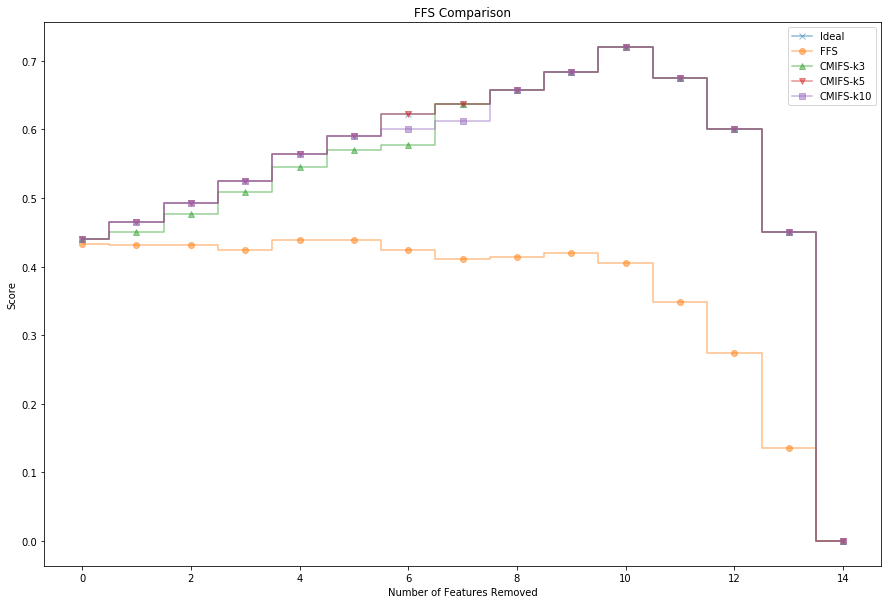

In [36]:
fig2 = plot_scores(scores, (15,10))

In [37]:
fig2.savefig("images/ffs-comparison7k.png")

In [32]:
for x in cmifs_hist:
    print(x)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}, 0.0)
({0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13}, 43.52515190222519)
({0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13}, 76.46626148787406)
({0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11}, 127.19679458547867)
({0, 1, 2, 3, 4, 7, 8, 9, 10, 11}, 178.01577216095978)
({0, 1, 2, 3, 4, 7, 8, 9, 10}, 225.01559839887616)
({0, 1, 2, 3, 4, 7, 8, 10}, 277.2441637562933)
({0, 1, 3, 4, 7, 8, 10}, 306.9400519795808)
({0, 1, 3, 7, 8, 10}, 330.6221180160229)
({0, 1, 3, 7, 8}, 397.71079353501386)
({0, 1, 8, 7}, 464.0470773875389)
({0, 1, 8}, 595.1037025352081)
({8, 1}, 694.5528152285843)
({1}, 804.1249899846797)
(set(), 865.5253164680465)


In [33]:
def mean_merge_dict(dicts):
    scores = {}
    for d in dicts:
        for k in d:
            if k not in scores:
                scores[k] = d[k].copy()
            else :
                scores[k] += d[k]
    for k in scores:
        scores[k] /= len(dicts)
    return scores